# Tutorial 1

**Credits**: Andrea Galassi, Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Data loading, Feature Extraction, Machine Learning, Text Classification, Sentiment Analysis

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

## Important

**Make sure** to put all of us in cc when contacting us via mail!

## PART I ($\sim$10 mins)

*   How to **download** a dataset.
*   How to **inspect** a dataset.

## PART II ($\sim$20 mins)

* How to perform basic **text pre-processing** to identify input features.

## PART III ($\sim$20 mins)

*   How to **train a classifier** on identified input features for sentiment classification.
*   How to **evaluate** model performance and **inspect** its predictions.

## Task

We consider the task of **document classification**.

Specifically, we consider document **sentiment analysis** on movie reviews.

## Preliminaries

First of all, we need to import some useful packages that we will use during this hands-on session.

In [1]:
# file management
import sys
import shutil
import urllib
import tarfile
from pathlib import Path

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from typing import Iterable

# viz
from tqdm import tqdm

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

{'width': 1024, 'height': 768, 'scroll': True}

# 1. Downloading the dataset

We download the IMDB movie reviews dataset.

In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


In [4]:
def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    print("Extraction completed!")

In [5]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_name = "aclImdb"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")


Current work directory: c:\Users\giuli\Documents\Progetti uni\NLP-LAB\tutorial-1\tutorial-1


In [6]:
if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_tar_path = dataset_folder.joinpath("Movies.tar.gz")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_tar_path.exists():
    download_dataset(dataset_tar_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_tar_path, dataset_folder)

Let's have a look at the files we have downloaded to understand the dataset structure.

In [7]:
# an example
file_path = dataset_folder.joinpath(dataset_name,
                                    'train',
                                    'pos', 
                                    "0_9.txt")

if file_path.is_file():
    # open the file
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        print(text)

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


## 1.1 Encode the dataset into a pandas.DataFrame

We encode the loaded dataset into a dataframe to better access to its content.

In [8]:
dataframe_rows = []

for split in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        folder = dataset_folder.joinpath(dataset_name, split, sentiment)
        for file_path in folder.glob('*.txt'):            
            with file_path.open(mode='r', encoding='utf-8') as text_file:
                text = text_file.read()
                score = file_path.stem.split("_")[1]
                score = int(score)
                file_id = file_path.stem.split("_")[0]

                num_sentiment = 1 if sentiment == 'pos' else 0

                dataframe_row = {
                    "file_id": file_id,
                    "score": score,
                    "sentiment": num_sentiment,
                    "split": split,
                    "text": text
                }

                dataframe_rows.append(dataframe_row)

In [9]:
folder = Path.cwd().joinpath("Datasets", "Dataframes", dataset_name)
if not folder.exists():
    folder.mkdir(parents=True)

# transform the list of rows in a proper dataframe
df = pd.DataFrame(dataframe_rows)
df = df[["file_id", 
         "score",
         "sentiment",
         "split",
         "text"]
       ]
df_path = folder.with_name(dataset_name + ".pkl")
df.to_pickle(df_path)

## 1.2 Inspecting the dataset

We first have a look at the dataframe structure.

In [10]:
print("Dataframe structure:")
print(df)
print()

Dataframe structure:
      file_id  score  sentiment  split  \
0           0      9          1  train   
1       10000      8          1  train   
2       10001     10          1  train   
3       10002      7          1  train   
4       10003      8          1  train   
...       ...    ...        ...    ...   
49995    9998      1          0   test   
49996    9999      1          0   test   
49997     999      3          0   test   
49998      99      3          0   test   
49999       9      4          0   test   

                                                    text  
0      Bromwell High is a cartoon comedy. It ran at t...  
1      Homelessness (or Houselessness as George Carli...  
2      Brilliant over-acting by Lesley Ann Warren. Be...  
3      This is easily the most underrated film inn th...  
4      This is not the typical Mel Brooks film. It wa...  
...                                                  ...  
49995  I occasionally let my kids watch this garbage ...  
49

In [11]:
print("Total rows %d" % (len(df)))
print()

Total rows 50000



In [12]:
print("Distribution of scores: ")
print(df['score'].value_counts())
print()

Distribution of scores: 
score
1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: count, dtype: int64



In [13]:
print("Distribution of sentiment: ")
print(df['sentiment'].value_counts())
print()

Distribution of sentiment: 
sentiment
1    25000
0    25000
Name: count, dtype: int64



In [14]:
print("Distribution of splits: ")
print(df['split'].value_counts())
print()

Distribution of splits: 
split
train    25000
test     25000
Name: count, dtype: int64



In [15]:
print("Distribution of sentiments in split: ")
print(df.groupby(['split','sentiment']).size())
print()

Distribution of sentiments in split: 
split  sentiment
test   0            12500
       1            12500
train  0            12500
       1            12500
dtype: int64



In [16]:
print("Distribution of scores in split: ")
print(df.groupby(['split','score']).size())
print()

Distribution of scores in split: 
split  score
test   1        5022
       2        2302
       3        2541
       4        2635
       7        2307
       8        2850
       9        2344
       10       4999
train  1        5100
       2        2284
       3        2420
       4        2696
       7        2496
       8        3009
       9        2263
       10       4732
dtype: int64



In [17]:
print("Differences in score distribution in split: ")
print(df.groupby(['score','split',]).size())
print()

Differences in score distribution in split: 
score  split
1      test     5022
       train    5100
2      test     2302
       train    2284
3      test     2541
       train    2420
4      test     2635
       train    2696
7      test     2307
       train    2496
8      test     2850
       train    3009
9      test     2344
       train    2263
10     test     4999
       train    4732
dtype: int64



In [18]:
print("Differences among score classes in the splits: ")
print(df.groupby(['sentiment','score','split']).size())
print()

Differences among score classes in the splits: 
sentiment  score  split
0          1      test     5022
                  train    5100
           2      test     2302
                  train    2284
           3      test     2541
                  train    2420
           4      test     2635
                  train    2696
1          7      test     2307
                  train    2496
           8      test     2850
                  train    3009
           9      test     2344
                  train    2263
           10     test     4999
                  train    4732
dtype: int64



### 1.2.1 Visualization

In [19]:
# Preliminaries
import matplotlib.pyplot as plt

We first visualize sentiment class distribution.

In [20]:
train_labels = df[df.split == 'train'].sentiment.values
test_labels = df[df.split == 'test'].sentiment.values

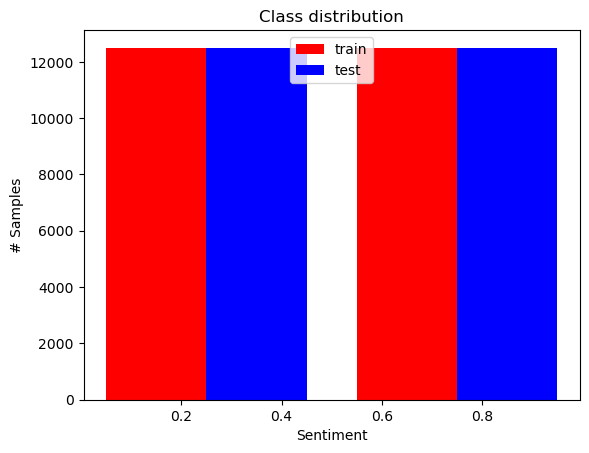

In [21]:
plt.hist([train_labels,test_labels], bins=2, label=['train','test'],
         color=["red", "blue"], align="mid")
plt.legend(loc='upper center')
plt.title('Class distribution')
plt.xlabel('Sentiment')
plt.ylabel('# Samples')
plt.show()

Then we visualize sentiment scores.

In [22]:
train_scores = df[df.split == 'train'].score.values
test_scores = df[df.split == 'test'].score.values

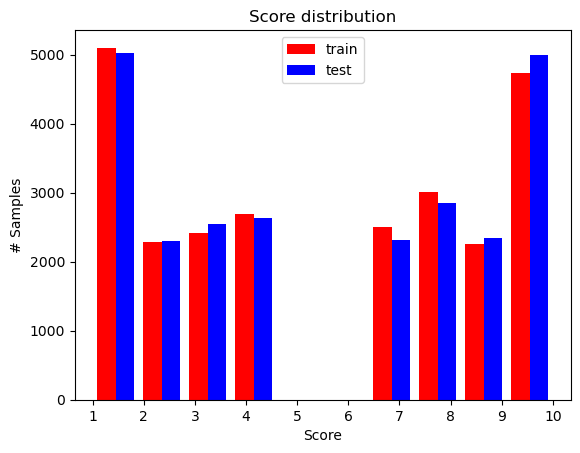

In [23]:
plt.xticks(range(1,11))
plt.hist([train_scores,test_scores], bins=10, label=['train','test'], color=["red", "blue"], align="mid")
plt.legend(loc='upper center')
plt.title('Score distribution')
plt.xlabel('Score')
plt.ylabel('# Samples')

plt.show()

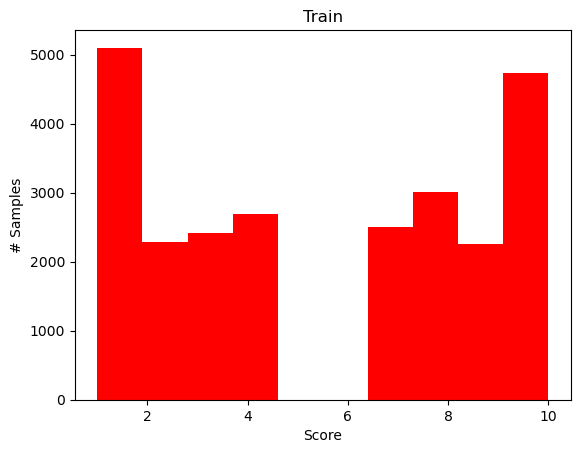

In [24]:
plot1 = plt.figure(1)
plt.hist(train_scores, 10, color="red")
plt.xlabel('Score')
plt.ylabel('# Samples')
plt.title("Train")
plt.show()

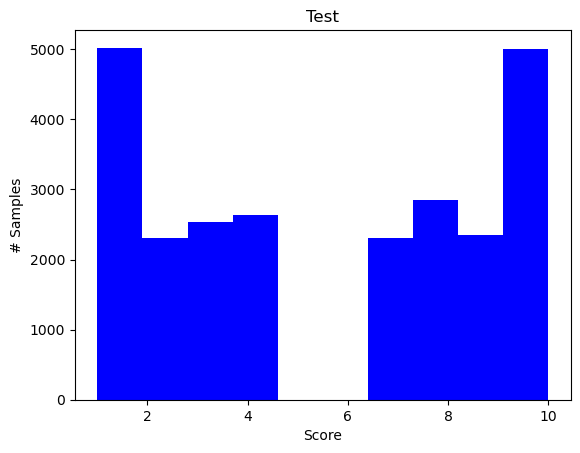

In [25]:
plot2 = plt.figure(2)
plt.hist(test_scores, 10, color="blue")
plt.xlabel('Score')
plt.ylabel('# Samples')
plt.title("Test")
plt.show()

Lastly, we check text length distribution.

In [26]:
import nltk
from nltk.tokenize import word_tokenize

# necessary for being able to tokenize
nltk.download('punkt_tab')
nltk.download('punkt')

train_texts = df[df.split == 'train'].text.values
test_texts = df[df.split == 'test'].text.values

train_lengths = [len(word_tokenize(text)) for text in tqdm(train_texts)]
test_lengths = [len(word_tokenize(text)) for text in tqdm(test_texts)]

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 25000/25000 [00:23<00:00, 1046.28it/s]


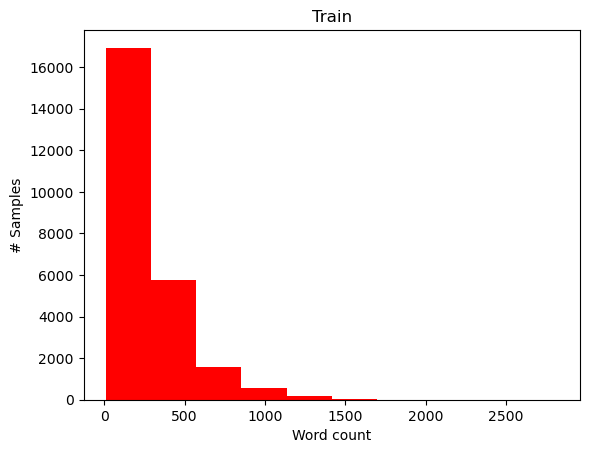

In [27]:
plot1 = plt.figure(1)
plt.hist(train_lengths, color="red")
plt.xlabel('Word count')
plt.ylabel('# Samples')
plt.title("Train")
plt.show()

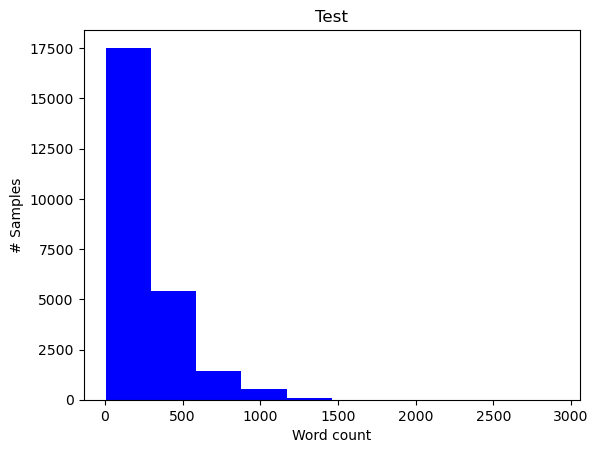

In [28]:
plot2 = plt.figure(2)
plt.hist(test_lengths, 10, color="blue")
plt.xlabel('Word count')
plt.ylabel('# Samples')
plt.title("Test")
plt.show()

## 2. Feature Extraction

We are now ready to address the sentiment analysis task.

We consider the sentiment classification task for description purposes.

We first **determine** the inputs and outputs of our classifier.

Then, we define **how to encode** the inputs and outputs for the classifier.

### Inputs and Outputs

<center>
    <img src="images/inputs_outputs.png" alt="inputs and outputs" />
</center>

### Input features and Outputs

We will encode input text into a numerical format: **bag-of-words**.

<center>
    <img src="images/inputs_outputs_features.png" alt="features and outputs" />
</center>

Sentiment score prediction has the same schema where the *output label* is replaced by the sentiment score.

### 2.1 Bag-of-Words Encoding

The [scikit-learn](https://scikit-learn.org/stable/) library offers *TfidfVectorizer*, a class that performs both tokenization and the creation of the Bag-of-Words (BoW) representation of a corpus.

In particular, it computes tf-idf representation for each word token.

#### Homework 📖

The class has plenty of options: it can be used also to count n-grams, excluding stop-words, and cutting off most and/or less frequent terms.

In [29]:
from sklearn.feature_extraction.text import  TfidfVectorizer

# select only the training sentences
df_train = df.loc[df['split'] == "train"]

train_texts = df_train.text.values

print("Processing corpus\n")
vectorizer =  TfidfVectorizer()

# tokenization and creation of Bag of Words representation
X_train = vectorizer.fit_transform(train_texts)

print("Shape of the matrix: (data points, features)")
print(X_train.shape)
print()

# targets for the training set
Y_train = df_train.sentiment.values 

Processing corpus

Shape of the matrix: (data points, features)
(25000, 74849)



The vectorizer **fits** on the provided texts to create an internal vocabulary.

The vocabulary is used to create the BoW representation.

The vocabulary is a dictionary that associates to each word a corresponding column in the feature matrix.

#### Homework 📖

Do not try to print the whole vocabulary: it is quite large ;)

Still, **it is very important** to have a look at detected tokens!

Let's check the size of the built vocabulary.

In [30]:
print("Size of vocabulary:")
print(len(vectorizer.vocabulary_))
print(type(vectorizer.vocabulary_))

Size of vocabulary:
74849
<class 'dict'>


Since the vocabulary is quite big, the BoW representation of input texts is a *sparse* matrix (see [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) for more info).

Simply put, a sparse matrix is represented as a dictionary of non-zero entries, where the keys are the matrix coordinates.

In [31]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3445861 stored elements and shape (25000, 74849)>
  Coords	Values
  (0, 9251)	0.5528755709385473
  (0, 30902)	0.2616458445315301
  (0, 34585)	0.06440376302392932
  (0, 10850)	0.07578961903541269
  (0, 13498)	0.048831814194567884
  (0, 34683)	0.03238637557628514
  (0, 53427)	0.08287028364871561
  (0, 4753)	0.048168785663354516
  (0, 66339)	0.13179382548528576
  (0, 57283)	0.04380930936896619
  (0, 66925)	0.029795090371297454
  (0, 4465)	0.041794821579948516
  (0, 61617)	0.028352823944477742
  (0, 47407)	0.033612394453386325
  (0, 51933)	0.10142198326143342
  (0, 1277)	0.02713338360986115
  (0, 58026)	0.11599167114999774
  (0, 38683)	0.03904856857687559
  (0, 64115)	0.04105492761350832
  (0, 65748)	0.40298549004690387
  (0, 44639)	0.06171076675987137
  (0, 646)	0.09530469501371355
  (0, 74158)	0.04248395158188171
  (0, 33004)	0.032707474206810465
  (0, 65750)	0.09813523499426788
  :	:
  (24999, 54664)	0.10006234568899015
  (24

It is possible to get the dense representation of a feature matrix.

**Keep in mind** that the matrix will occupy a lot of memory.

In [32]:
print(X_train.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.08332142 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


#### Homework 📖

Try taking a subset of the matrix and inspect its dense representation.

We use our fitted Vectorizer to transform test texts as well.

**Make sure** you invoke ``vectorizer.transform()`` and **not** ``vectorizer.fit_transform()``.

In [33]:
# select only the test sentences
df_test = df.loc[df['split'] == "test"]
test_texts = df_test.text.values

X_test = vectorizer.transform(test_texts)
Y_test = df_test.sentiment.values

**GOLDEN RULE: DO NOT EVER EVER EVER EVER MESS WITH THE TEST SET!!!!**

You **should never** add or remove rows/instances/data points from the test set.

You **should never** alter the ground-truth labels.

You **can** process it to transform, add, or remove columns/features.

You **can** modify the train set more freely.


But **keep your gross fingerprints** from the test set: it is untouchable, whatever its quality.

<br/>

<center>
    <img src="https://media.tenor.com/rPtHkeV2tkYAAAAC/stay-away-coronavirus.gif" alt="features and outputs" />
</center>

So far, we have encoded the text as it is.

We can perform additional pre-processing to 'normalize' the provided text.

### 2.2 Stemming

*''Stemming usually refers to a crude heuristic process that **chops off** the ends of words to reduce words to a common form.''* 

<div align='right'>
(Introduction to Information Retrieval ~ C. D. Manning)
</div>

**Example**

*programmer*, *programs*, *programming* $\rightarrow$ *program*

In [34]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import (word_tokenize,
 sent_tokenize,
 WhitespaceTokenizer)

stemmer = SnowballStemmer("english")
tokenizer = WhitespaceTokenizer()

In [35]:
def stem_text(text: str):
    words = [stemmer.stem(word) for word in tokenizer.tokenize(text)]
    return " ".join(words)

st_train_texts = [stem_text(text) for text in tqdm(train_texts)]
st_test_texts = [stem_text(text) for text in tqdm(test_texts)]

100%|██████████| 25000/25000 [00:26<00:00, 957.23it/s] 


In [36]:
print(train_texts[0][:100])
print()
print(st_train_texts[0][:100])

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life,

bromwel high is a cartoon comedy. it ran at the same time as some other program about school life, s


We encoded the pre-processed texts as before via the ``TfidfVectorizer``.

In [37]:
print("Processing corpus\n")
st_vectorizer =  TfidfVectorizer()
st_X_train = st_vectorizer.fit_transform(st_train_texts)
st_X_test = st_vectorizer.transform(st_test_texts)

print("Shape of the matrix: (data points, features)")
print(st_X_train.shape)
print()

Processing corpus

Shape of the matrix: (data points, features)
(25000, 70363)



### 2.3 Lemmatization

*''Lemmatization usually refers to use a vocabulary and morphological analysis of words to return the base or dictionary form of a word, known as **lemma**''*

<div align='right'>
(Introduction to Information Retrieval ~ C. D. Manning)
</div>

**Example**

*saw*, *seen*, *sees* $\rightarrow$ *see*

In [38]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


In [39]:
def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) 
             for word, tag in tagged]
    return " ".join(words)

In [40]:
lem_train_texts = [lem_text(text) 
                   for text in tqdm(train_texts,
                                    leave=True,
                                    position=0)]
lem_test_texts = [lem_text(text) 
                  for text in tqdm(test_texts,
                                   leave=True,
                                   position=0)]

100%|██████████| 25000/25000 [06:23<00:00, 65.15it/s] 


In [41]:
print(train_texts[50][:100])
print()
print(lem_train_texts[50][:100])

I find it so amazing that even after all these years, we are STILL talking about this movie! Obvious

I find it so amaze that even after all these years, we be STILL talk about this movie! Obviously thi


We encoded the pre-processed texts as before via the ``TfidfVectorizer``.

In [42]:
print("Processing corpus\n")
lem_vectorizer =  TfidfVectorizer()
lem_X_train = lem_vectorizer.fit_transform(lem_train_texts)
lem_X_test = lem_vectorizer.transform(lem_test_texts)

print("Shape of the matrix: (data points, features)")
print(lem_X_train.shape)
print()

Processing corpus

Shape of the matrix: (data points, features)
(25000, 70649)



## 3. Training and Evaluating a Classifier

We are now ready to try out some standard machine learning classifiers.

**But** first, we introduce some baselines.

#### The importance of defining good baselines

Good baselines are always needed to consistently evaluate employed models.

When proposing a novel model, good baselines are recent state-of-the-art models.

When proposing a benchmark, good baselines are general-purpose off-the-shelf models.

### 3.1 Baselines

The majority baseline always predicts the majority class.

The random baseline makes uniform random predictions.

Their performances will tell us how much difficult this task is.

In [43]:
from sklearn.dummy import DummyClassifier

majority_classifier = DummyClassifier(strategy="prior")
uniform_classifier = DummyClassifier(strategy="uniform")

majority_classifier.fit(X_train, Y_train)
uniform_classifier.fit(X_train, Y_train)

Y_pred_train_maj = majority_classifier.predict(X_train)
Y_pred_test_maj = majority_classifier.predict(X_test)
Y_pred_train_uni = uniform_classifier.predict(X_train)
Y_pred_test_uni = uniform_classifier.predict(X_test)

#### Homework 📖

Try out a random baseline that samples predictions according to label distribution.

We now evaluate model predictions via some metrics.

In [44]:
from sklearn.metrics import classification_report

def evaluate_classification(y_true, y_pred):
    report = classification_report(y_true,
                                   y_pred,
                                   target_names=['neg', 'pos'])
    print(report)

In [45]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_maj)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_maj)

              precision    recall  f1-score   support

         neg       0.50      1.00      0.67     12500
         pos       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000

              precision    recall  f1-score   support

         neg       0.50      1.00      0.67     12500
         pos       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



c:\Users\giuli\.conda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\giuli\.conda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\giuli\.conda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\g

In [46]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_uni)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_uni) 

              precision    recall  f1-score   support

         neg       0.50      0.51      0.50     12500
         pos       0.50      0.49      0.50     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000

              precision    recall  f1-score   support

         neg       0.50      0.49      0.49     12500
         pos       0.50      0.50      0.50     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000



#### 3.1.1 The importance of model evaluation

In most cases, accuracy is **not a very informative metric**. 

Precision, recall, and F1 are more informative

F1 is generally a good indicator. In particular, macro F1 in case the test set in unbalanced.

Whether precision or recall are more important depends on the specific application, if the priority is to avoid false positives or false negatives.

Other metrics do exists (e.g., Area Under ROC Curve), always check the literature to find the most informative way to measure something!

#### Homework 📖

Try sampling an unbalanced test set and run model evaluation.

Do you see any differences in terms of metric values?

In [47]:
# plot precision/recall curve and confusion matrix
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay,
                             ConfusionMatrixDisplay,
                             PrecisionRecallDisplay)

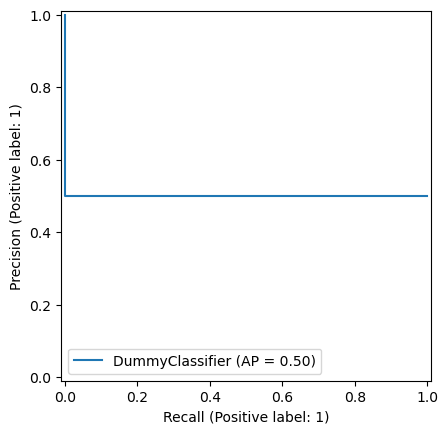

In [48]:
PrecisionRecallDisplay.from_estimator(majority_classifier, X_test, Y_test)

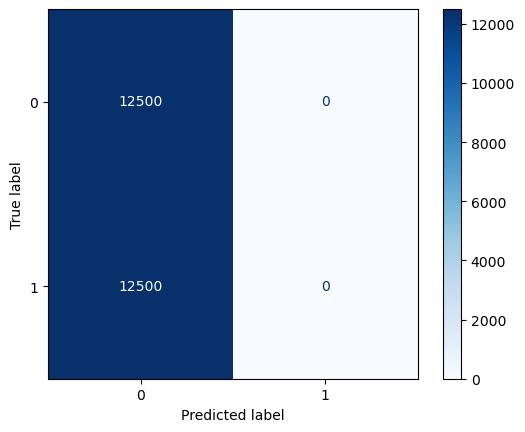

In [49]:
ConfusionMatrixDisplay.from_estimator(majority_classifier, X_test, Y_test, normalize=None, cmap=plt.cm.Blues)

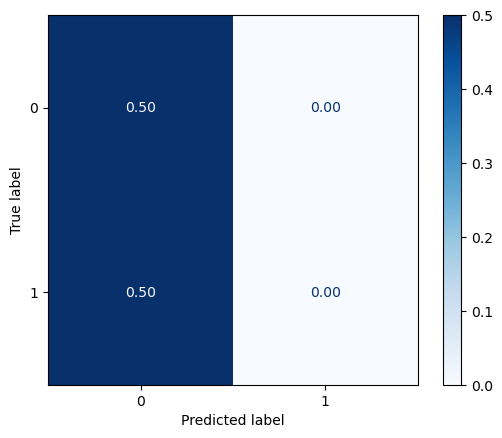

In [50]:
ConfusionMatrixDisplay.from_estimator(majority_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

In most cases it is better to use the normalized version, especially with unbalanced distributions!

Looking at confusion tables row-wise gives information about recall, looking column-wise gives information about precision.

<center>
    <img src="images/confusion_matrix.png" alt="confusion matrix" />
</center>

<div align='right'>
(wikipedia)
</div>

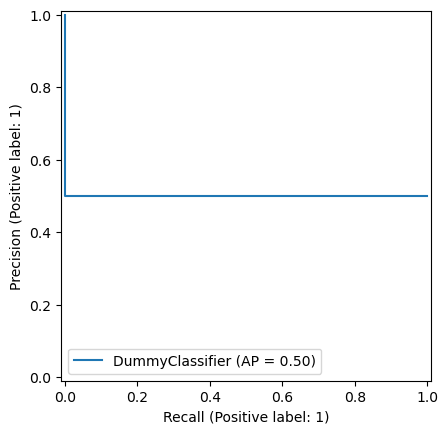

In [51]:
PrecisionRecallDisplay.from_estimator(uniform_classifier, X_test, Y_test)

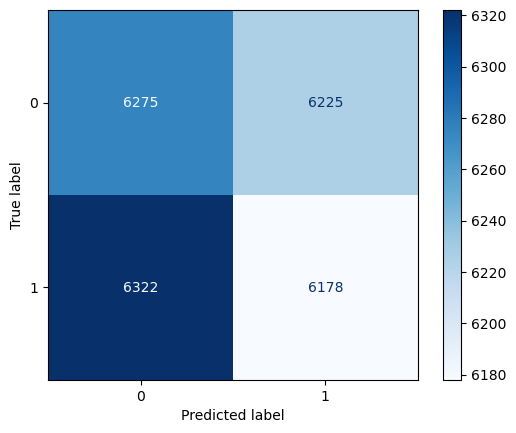

In [52]:
ConfusionMatrixDisplay.from_estimator(uniform_classifier, X_test,
                                      Y_test, normalize=None, cmap=plt.cm.Blues)

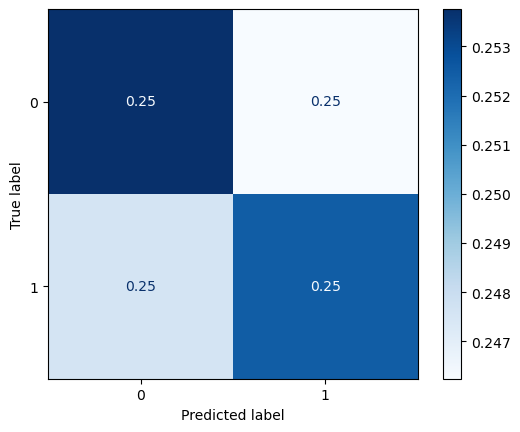

In [53]:
ConfusionMatrixDisplay.from_estimator(uniform_classifier, X_test, Y_test,
                                      normalize='all', cmap=plt.cm.Blues,
                                      values_format=".2f")

### 3.2 Bayes Classifier

Let's try out our first classifier: A Naive Bayes Classifier (NB).

In [54]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, Y_train)

Y_pred_train_nb = nb_classifier.predict(X_train)
Y_pred_test_nb = nb_classifier.predict(X_test)

In [55]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_nb)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_nb)

              precision    recall  f1-score   support

         neg       0.89      0.93      0.91     12500
         pos       0.93      0.89      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

              precision    recall  f1-score   support

         neg       0.79      0.89      0.84     12500
         pos       0.87      0.77      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



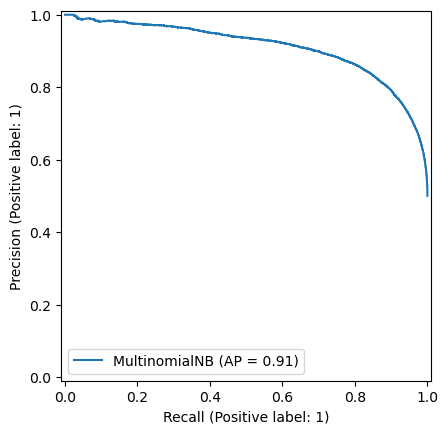

In [56]:
PrecisionRecallDisplay.from_estimator(nb_classifier, X_test, Y_test)

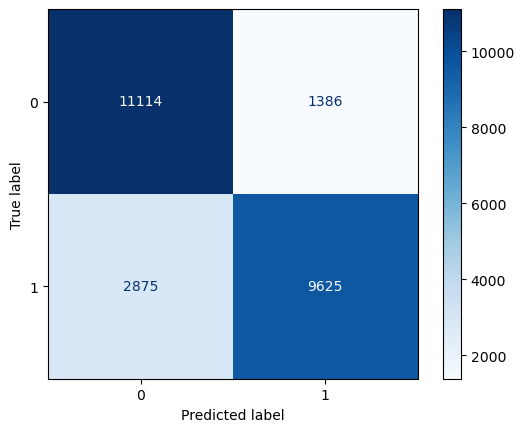

In [57]:
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_test,
                                      Y_test, cmap=plt.cm.Blues)

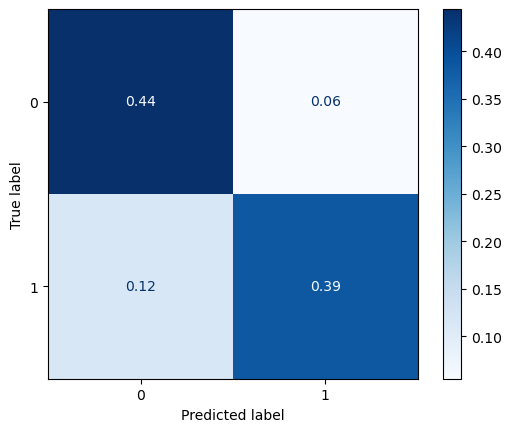

In [58]:
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_test, Y_test,
                                      normalize='all', cmap=plt.cm.Blues,
                                      values_format=".2f")

### 3.3 SVC Classifier

We consider another classifier: a Support Vector Machine (SVM).

In [59]:
from sklearn.svm import LinearSVC

svc_classifier = LinearSVC()

svc_classifier.fit(X_train, Y_train)

Y_pred_train_svc = svc_classifier.predict(X_train)
Y_pred_test_svc = svc_classifier.predict(X_test)

In [60]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.87      0.89      0.88     12500
         pos       0.89      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



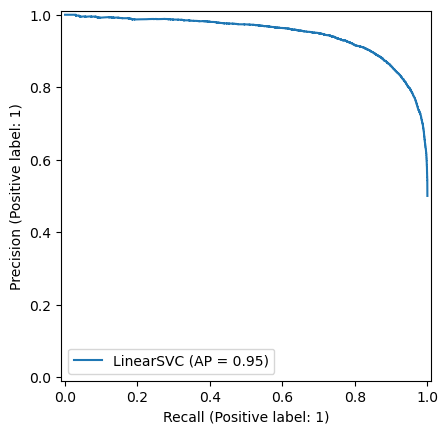

In [61]:
PrecisionRecallDisplay.from_estimator(svc_classifier, X_test, Y_test)

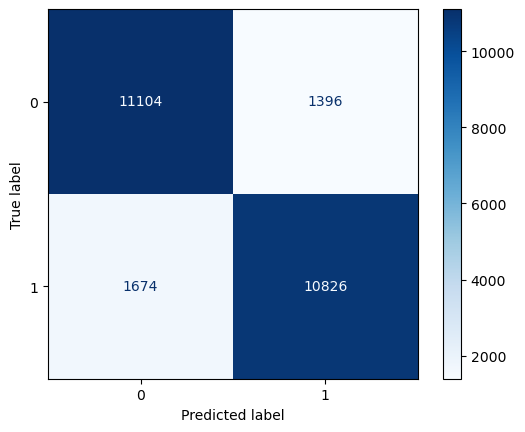

In [62]:
ConfusionMatrixDisplay.from_estimator(svc_classifier, X_test,
                                      Y_test, cmap=plt.cm.Blues)

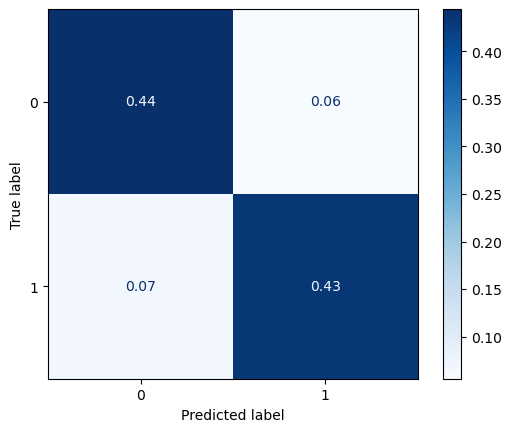

In [63]:
ConfusionMatrixDisplay.from_estimator(svc_classifier, X_test, Y_test,
                                      normalize='all', cmap=plt.cm.Blues,
                                      values_format=".2f")

### 3.4 Error Analysis

Let's try to understand what kind of errors are done by the model. 

We can look at specific cases of error.

In [64]:
# confidence of the model
confidence = svc_classifier.decision_function(X_test)

fp_i = []
fn_i = []
fp_v = []
fn_v = []
fp_c = []
fn_c = []

for index, value in enumerate(Y_test):
    # false positives
    if value==0 and Y_pred_test_svc[index]==1:
        fp_i.append(index)
        fp_v.append(value)
        fp_c.append(confidence[index])
    # false negatives
    elif value==1 and Y_pred_test_svc[index]==0:
        fn_i.append(index)
        fn_v.append(value)
        fn_c.append(confidence[index])

Let's print some examples of FN and FP and the confidence in their classification

In [65]:
print("FN")
print(test_texts[fn_i[1]])
print(fn_c[1])

FN
Even if you're a fan of Jean Rollin's idiosyncratic body of work, you will be caught off guard by this exceptional foray into science fiction territory. For once, there's not a single diaphanously gowned vampire girl in sight ! True to tradition, the budget proved way too tight to realize the director's vision entirely. Yet this is largely compensated by his obvious love of genre cinema, dedication to his craft and sheer ingenuity. Jean-Claude Couty's atmospheric cinematography makes the most of the foreboding locations and Philippe Bréjean (a/k/a "Gary Sandeur") contributes a startling soundtrack that fortunately doesn't resemble any of the sappy stuff he composed for hardcore.<br /><br />Shot in and around a Paris office block before and after working hours, the film was largely cast with porn regulars Rollin was already quite familiar with from his "Michel Gentil" cash-gathering XXX efforts, most notably French f*ck film royalty Brigitte Lahaie in the demanding lead. Playing Elis

In [66]:
print("FP")
print(test_texts[fp_i[5]])
print(fp_c[5])

FP
This tale of the upper-classes getting their come-uppance and wallowing in their high-class misery is like a contemporary Mid-Sommerish version of an old Joan Crawford movie in which she suffered in mink. Here, people behave in a frightfully civilized manner in the face of adversity. A well-heeled London solicitor, (Tom Wilkinson), discovers that not only is his wife having an affair with the local gentry but that she has also killed their housekeeper's husband in a hit-and-run accident. He throws up, but otherwise his stiff-upper-lip hardly quavers.<br /><br />Written and directed by Julian Fellowes, who won an Oscar for writing "Gosford Park", (this is his directorial debut), from a novel by Nigel Balchin, it's quite comical although I am not sure how much of the comedy is intended. It's like a throw-back to British films of the forties where characters all behaved like characters in books or plays rather than like people might in real life. However, it's not all bad. Wilkinson is

We now check the sentences for which the classification error is bigger.

In [67]:
max_fp = fp_c.index(max(fp_c))
print(test_texts[fp_i[max_fp]])
print(fp_c[max_fp])

This movie was pure genius. John Waters is brilliant. It is hilarious and I am not sick of it even after seeing it about 20 times since I bought it a few months ago. The acting is great, although Ricki Lake could have been better. And Johnny Depp is magnificent. He is such a beautiful man and a very talented actor. And seeing most of Johnny's movies, this is probably my favorite. I give it 9.5/10. Rent it today!
2.070316252687478


In [68]:
# for false negatives the confidence is negative
max_fn = fn_c.index(min(fn_c))
print(test_texts[fp_i[max_fn]])
print(fn_c[max_fn])

All I can do is echo the sentiment already expressed by some of the other commenters. This is CITY OF GOD meets HAPPY DAYS. The bipolarity of the ruthless thug (one minute a ruthless killer, the next minute a Luv's diaper commercial) is completely unconvincing. You can approach it in one of two ways: (1) A gritty, realistic movie turned sappy; or (2) a sappy, ABC-afterschool-special with profanity, violence and animal cruelty. Either way it just don't fly, do it? Why then has it received so much praise? As others have implied, it gets the "conscience vote" from the west. Show us pictures of poverty to contrast against our fluffy, double-wide theatre seats and 44-oz cokes, and we'll applaud in a heartbeat. But--oh--don't forget to candy coat it, because the bitter pill of reality (tantalizing as it is) is hard for us to swallow.<br /><br />I'm terribly disappointed that this film would receive so many awards and accolades, especially when there are far more deserving works of film out t

Let's now consider the stemmed and lemmatized versions of our input features.

In [69]:
svc_classifier_st = LinearSVC()

svc_classifier_st.fit(st_X_train, Y_train)

Y_pred_train_svc_st = svc_classifier_st.predict(st_X_train)
Y_pred_test_svc_st = svc_classifier_st.predict(st_X_test)

In [70]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc_st)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc_st)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.87      0.88      0.87     12500
         pos       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [71]:
svc_classifier_lem = LinearSVC()

svc_classifier_lem.fit(lem_X_train, Y_train)

Y_pred_train_svc_lem = svc_classifier_lem.predict(lem_X_train)
Y_pred_test_svc_lem = svc_classifier_lem.predict(lem_X_test)

In [72]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc_lem)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc_lem)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.86      0.88      0.87     12500
         pos       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



### 3.4.1 Comparisons

Let's organize our results in a Table to better compare models.

| Model       | F1-macro |
| ---         | ---      |
| Random      | .50      |
| Majority    | .33      |
| NB          |  .83     |
| SVM         | **.88**      |
| SVM w/ Stem | .87      |
| SVM w/ Lem  | .87      |

#### Homework

Try out the NB classifier with Stemmed and Lemmatized input features, respectively.

What do you observe?

# The End!